# Time series forecasting algorithms in PyAF

This document describes the algorithmic aspects of time series forecasting in PyAF. 

We will cover:

1. The overall algorithm
2. The detail of the signal decomposition
3. The machine learning aspects
4. Model Customization. Advanced usage/control of the algorithms.
5. Reproducibility of PyAF models
6. Model Explainability
7. Model Outputs

Warning : This document ins intended for advanced uses of PyAF. The aspects described here are not useful in a typical forecasting use case. Feedback is welcome here.


## Overall Algorithm

PyAF uses a machine learning approach to forecasting. A lot of time series models are generated and their forecasting quality is compared on a validation dataset (most recent part of the whole signal). 
To summarize, PyAF is performing a competition between a large set of possible models/hypothesis and selecting the best to perform the final forecast.

the models used/tested in PyAF are signal decompositions generated on the fly internally. An additive signal decomposition is the sum of a **trend** (long term) , **periodic** and an **irregular** component as described in http://en.wikipedia.org/wiki/Decomposition_of_time_series

Fro the theoretical aspects, PyAF uses standard methods and a lot of best practices. When not specified, the theoretical aspects are mainly inspired by the excellent approach used in [Rob J Hyndman and George Athanasopoulos book](http://www.otexts.org/fpp3/).

PyAF generates tens of possible decompositions for the input signal and outputs the best. One can control the amount/types of decompositions, enable/disable such of such component,  and review the performance of each decomposition internally.

In addition to the decomposition , PyAF allows a whole set of possible **signal transformations** performed in a pre-processing phase (before decomposition) and a  post-processing step (after forecasting).

PyAF performs the forecasting task of a signal $X_t$ in three steps described below:

1. Signal Transformation : $$ Y_t = \phi(X_t) $$
2. Decomposition of the transformed signal (non-additive decompositions are also supported): $$ \hat{Y_t} = T_t + C_t + I_t $$
3. Back transformation of the forecast : $$ \hat{X_t}  = \phi^{-1}(\hat{Y_t}) $$


## Signal Decompositions with PyAF

 PyAF supports the following operations :

In [1]:
lKnownDecompositions = ['T+S+R' , 'TS+R', 'TSR']

lKnownTransformations = ['None', 'Difference', 'RelativeDifference','Integration', 'BoxCox', 'Quantization', 'Logit', 'Fisher', 'Anscombe'];

lKnownTrends = ['ConstantTrend', 'Lag1Trend', 'LinearTrend', 'PolyTrend','MovingAverage', 'MovingMedian'];

lKnownPeriodics = ['NoCycle', 'BestCycle',
                   'Seasonal_MonthOfYear' ,
                   'Seasonal_Second' ,
                   'Seasonal_Minute' ,
                   'Seasonal_Hour' ,
                   'Seasonal_HourOfWeek' ,
                   'Seasonal_TwoHourOfWeek' ,
                   'Seasonal_ThreeHourOfWeek' ,
                   'Seasonal_FourHourOfWeek' ,
                   'Seasonal_SixHourOfWeek' ,
                   'Seasonal_EightHourOfWeek' ,
                   'Seasonal_TwelveHourOfWeek' ,
                   'Seasonal_DayOfWeek' ,
                   'Seasonal_DayOfMonth',
                   'Seasonal_DayOfYear',
                   'Seasonal_WeekOfMonth',
                   'Seasonal_DayOfNthWeekOfMonth',
                   'Seasonal_WeekOfYear']

# 'X' at the end , means with exogenous data (when available).
lKnownAutoRegressions = ['NoAR' , 
                         'AR' , 'ARX' , 
                         'SVR', 'SVRX', 
                         'MLP' , 'MLPX',
                         'LSTM' , 'LSTMX',
                         'XGB' , 'XGBX' , 
                         'CROSTON', 
                         'LGB', 'LGBX'];





In [2]:
import numpy as np
import pandas as pd

N = len(lKnownPeriodics)
df = pd.DataFrame(index = range(N))
df['Transformation'] = lKnownTransformations + [""]*(N - len(lKnownTransformations))
df['Decomposition'] = lKnownDecompositions + [""]*(N - len(lKnownDecompositions))
df['Trend'] = lKnownTrends + [""]*(N - len(lKnownTrends))
df['Periodics'] = lKnownPeriodics + [""]*(N - len(lKnownPeriodics))
df['Irregular'] = lKnownAutoRegressions + [""]*(N - len(lKnownAutoRegressions))

df.head(N)

,Transformation,Decomposition,Trend,Periodics,Irregular
0,None,T+S+R,ConstantTrend,NoCycle,NoAR
1,Difference,TS+R,Lag1Trend,BestCycle,AR
2,RelativeDifference,TSR,LinearTrend,Seasonal_MonthOfYear,ARX
3,Integration,,PolyTrend,Seasonal_Second,SVR
4,BoxCox,,MovingAverage,Seasonal_Minute,SVRX
5,Quantization,,MovingMedian,Seasonal_Hour,MLP
6,Logit,,,Seasonal_HourOfWeek,MLPX
7,Fisher,,,Seasonal_TwoHourOfWeek,LSTM
8,Anscombe,,,Seasonal_ThreeHourOfWeek,LSTMX
9,,,,Seasonal_FourHourOfWeek,XGB


PyAF tests every possible combination of these components, one of each column in the previous table. The user has the possibility to restrict each column and perform the training with the selected items (see customization below). 

Some algorithmic choices are made in pyaf (pandas operations are mainly column-based, dataframes are shared between various data processing steps, every signal transformation goes on specific thread). these choices make it possible to handle thousands of possible models. 

All the available CPUs can be used to accelerate PyAF training (minus a few to maintain a usable system ;). PyAF was tested on a machine with a xeon-phi CPU (https://github.com/antoinecarme/xeon-phi-data) which can process 256 threads simultaneously. 

By default, PyAF uses only the most common components (the first 3 or 4 of each column). The remaining components are optional and can be activated before training (see customization below)

We now give the possible values for each column , with their formula and specify when optional : 

### Transformations

1. None : $Y_t = \phi(X_t) = X_t $
2. Difference : $Y_t =  \phi(X_t) = X_t  - X_{t-1} $
3. Relative Difference : $Y_t =  \phi(X_t) = \frac{X_t  - X_{t-1}}{X_{t-1}} $
4. Integration : $Y_t =  \phi(X_t) = \sum_{s=0}^{s=t} X_s $

Optional Transformations:

5. BoxCox : $Y_t =  \phi(X_t) = \frac{X_t^\lambda - 1}{\lambda} $ (https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation)
6. Quantization : $Y_t =  \phi(X_t) = quantile(X_t) $
7. Logit : $Y_t =  \phi(X_t) = \frac{1}{1 + e^{-X_t}} $ (https://en.wikipedia.org/wiki/Logit)
8. Anscombe : $Y_t =  \phi(X_t) = 2 \sqrt{X_t + \frac{3}{8}} $ (https://en.wikipedia.org/wiki/Anscombe_transform)
9. Fisher : $Y_t =  \phi(X_t) = atanh(X_t) $ (https://en.wikipedia.org/wiki/Fisher_transformation)

### Trends



1. ConstantTrend : $T_t = a $
2. LinearTrend : $T_t = a t + b$
3. PolyTrend : $T_t = a t^2 + b t + c$
4. Lag1Trend : $T_t = Y_{t-1} $

Optional Trends

5. MovingAverage : $T_t = \sum_{s=t-k}^{s=t-1} Y_s$
6. MovingMedian : $T_t = median(Y_{t-k}, \dots, Y_{t-1})$



### Periodicities


1. NoCycle: $C_t = 0 $
2. BestCycle (extracted automatically, $p$ is estimated from data) : $ C_t = C_{t-p}$
3. Seasonality (depends on date parts) : $ C_t = minute(t) , hour(t), etc$
    These are seasonal components extracted from the signal. Some of these may not apply according to the time resolution used (hours in a daily signal), PyAF will ignore these. 



### Irregular Components

These models are built of the residues of trend and cycles:

$Z_t = Y_t - T_t - C_t $

We consider here some models based on the residue lags ($Lag(Z, k)_t = Z_{t-k}$).

The models described here as implemented using external libraries, either scikit-learn (AR, ARX, SVR), pytorch or keras (MLP, LSTM), XGBoost, LightGBM, ...

The default models are :

1. None : $I_t = 0$
2. Autoregressive (AR) model :  $I_t = a_0 + \sum_{k=1}^{k=p} a_k Z_{t-k}$
3. Autoregressive with Exogenous data (ARX) model :  $I_t = a_0 + \sum_{k=1}^{k=p} a_k Z_{t-k} + \sum_{k=1}^{k=p} b_k Exog_{t-k} $

Experimental Models : 

4. Support Vector Regression  (SVR) : $I_t = RBFKernel(target = Z_t , inputs = \{Z_{t-1} , \dots, Z_{t-p}\})$
5. MultiLayer Perceptron  (MLP) : $I_t = MLPRegressor(target = Z_t , inputs = \{Z_{t-1} , \dots, Z_{t-p}\})$
6. LSTM : $I_t = LSTMRegressor(target = Z_t , inputs = \{Z_{t-1} , \dots, Z_{t-p}\})$
7. XGB : $I_t = XGBoostRegressor(target = Z_t , inputs = \{Z_{t-1} , \dots, Z_{t-p}\})$
8. LGB : $I_t = LightGBMRegressor(target = Z_t , inputs = \{Z_{t-1} , \dots, Z_{t-p}\})$
6. CROSTON : $I_t = Croston(target = Z_t , inputs = \{Z_{t-1} , \dots, Z_{t-p}\})$

The parameter $p$ represents the dependency on the past. It can be [customized](https://github.com/antoinecarme/pyaf/blob/5f586e11abe4f8ede2caac6d818905d59b6356ba/pyaf/TS/Options.py#L228).

All these algorithms also support the usage of exogenous variables past (inputs = $\{Z_{t-1} , \dots, Z_{t-p}, Exog_{t-1}, \dots, Exog_{t-p}  \}$ instead of inputs = $\{Z_{t-1} , \dots, Z_{t-p}\}$), The naming convention is to use a 'X' suffix (i.e : 'LSTMX' is 'LSTM' with exogenous inputs)

## Machine Learning Aspects

By default, PyAF cuts the signal in three segments. 

1. The first part is used as an estimation dataset (~ first 80% of signal). It is used to define, for each model, the exact equation of the transformation, trends, periodics and AR components.
2. The second part is used as a validation dataset (next ~20% of the dataset), the models estimated on the first part are used to predict the values for the second , their performance indicators are computed, and the model with the best indicator is selected.
3. the last part of the signal (last values of the signal, length = Horizon), the test dataset, is used to get a set of indicators on a hold-out dataset that has the same size as requested forecasting horizon.

For each of these segments, a set of performance indicators for the best is re-computed after the training and displayed in the logs.

The size of the estimation dataset (~ 80% by default), can be customized before training through PyAF options (cSignalDecomposition_Options.mEstimRatio).

The following performance indicators are used in PyAF : 'MAPE', 'RMSE' or 'L2', 'MAE' or 'L1', 'SMAPE', 'MASE', 'ErrorMean', 'ErrorStdDev', 'R2', 'Pearson', 'MedAE', 'LnQ'.

PyAF uses MAPE as the default forecasting quality measure. The best model is selected based on this value on the validation dataset.

The user can define a different model selection quality measure before training using the pyaf options by setting cSignalDecomposition_Options.mModelSelection_Criterion.



## Model Customization

PyAF, by default, supports two modes of operation : **Fast Mode** and **Slow Mode**.

In Fast Mode, activated by default, an effort was made to give the most of PyAF in an acceptable training time. 
Only the non-optional models are activated in this mode.

In Slow Mode, all the models are activated , PyAF achieves better models but does no guarantee on computation times.

Some benchmarking and a lot of tests are performed to ensure that PyAF, even in slow mode, generates acceptable models within acceptable training times.

The user can customize PyAF to build intermediate models and restrict PyAF to use some categories of models. PyAF options allow this customization (https://github.com/antoinecarme/pyaf/blob/b614bfe24043a47e1aaf7cff36a1447b5dc431f6/pyaf/TS/Options.py#L13).

The following methods can be used to define the list of time series transformations, decomposition types and components (trends, cycles, ARs) that will be included :

1. cSignalDecomposition_Options.set_active_transformations(self, transformations)
2. cSignalDecomposition_Options.set_active_decomposition_types(self, iDecompTypes)
3. cSignalDecomposition_Options.set_active_trends(self, trends)
4. cSignalDecomposition_Options.set_active_periodics(self, periodics)
5. cSignalDecomposition_Options.set_active_autoregressions(self, autoregs)

When all of transformation/decompositions/components are disabled, a neutral one is used ('None', 'T+S+R', 'ConstantTrend', 'NoCycle', 'NoAR').

We give here an example of a model that only uses linear trends, some periodic components and an xgboost-based irregular component

     Month  Ozone       Time
0  1955-01    2.7 1955-01-01
1  1955-02    2.0 1955-02-01
2  1955-03    3.6 1955-03-01
3  1955-04    5.0 1955-04-01
4  1955-05    6.5 1955-05-01


INFO:pyaf.std:TIME_DETAIL TimeVariable='Time' TimeMin=1955-01-01T00:00:00.000000 TimeMax=1967-09-01T00:00:00.000000 TimeDelta=<DateOffset: months=1> Horizon=12
INFO:pyaf.std:SIGNAL_DETAIL_ORIG SignalVariable='Ozone' Length=204  Min=1.2 Max=8.7  Mean=3.835784 StdDev=1.491559
INFO:pyaf.std:SIGNAL_DETAIL_TRANSFORMED TransformedSignalVariable='_Ozone' Min=0.0 Max=1.0  Mean=0.351438 StdDev=0.198875
INFO:pyaf.std:DECOMPOSITION_TYPE 'T+S+R'
INFO:pyaf.std:BEST_TRANSOFORMATION_TYPE '_'
INFO:pyaf.std:BEST_DECOMPOSITION  '_Ozone_LinearTrend_residue_bestCycle_byMAPE_residue_XGB(51)' [LinearTrend + Cycle_None + XGB]
INFO:pyaf.std:TREND_DETAIL '_Ozone_LinearTrend' [LinearTrend]
INFO:pyaf.std:CYCLE_DETAIL '_Ozone_LinearTrend_residue_bestCycle_byMAPE' [Cycle_None]
INFO:pyaf.std:AUTOREG_DETAIL '_Ozone_LinearTrend_residue_bestCycle_byMAPE_residue_XGB(51)' [XGB]
INFO:pyaf.std:MODEL_MAPE MAPE_Fit=0.1259 MAPE_Forecast=0.1617 MAPE_Test=0.1725
INFO:pyaf.std:MODEL_SMAPE SMAPE_Fit=0.1155 SMAPE_Forecast=0.1679 


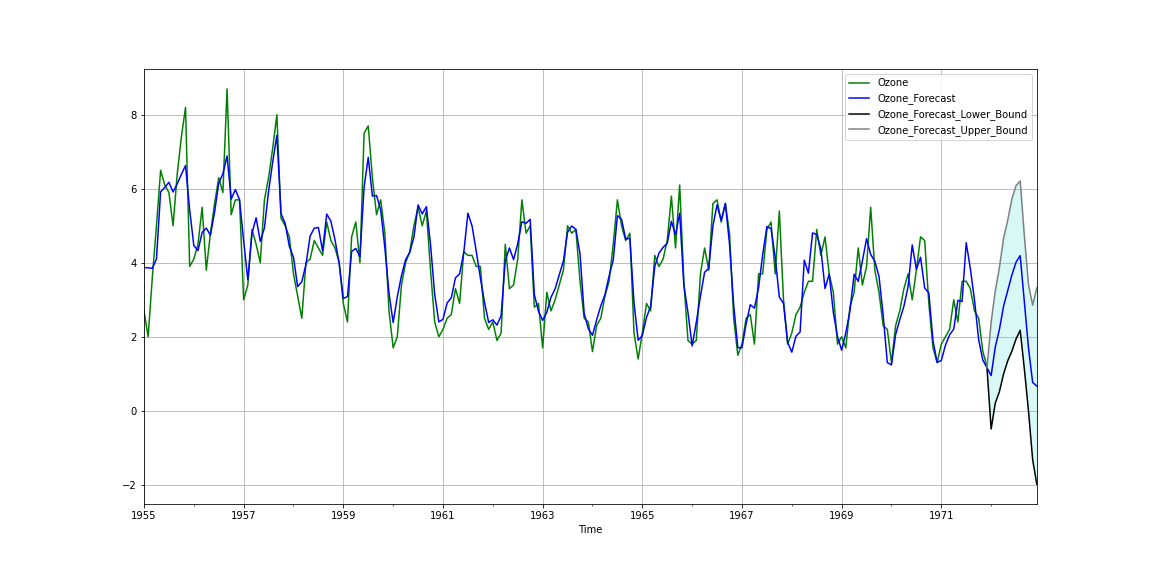

,Split,Transformation,DecompositionType,Model,DetailedFormula,Category,Complexity,FitMAPE,ForecastMAPE,TestMAPE
0,None,_Ozone,T+S+R,_Ozone_LinearTrend_residue_bestCycle_byMAPE_re...,"(_Ozone, T+S+R, None, _Ozone_LinearTrend_resid...",NoTransf_LinearTrend_Cycle_None_XGB,39.0,0.1259,0.1617,0.1725
1,None,_Ozone,T+S+R,_Ozone_LinearTrend_residue_Seasonal_MonthOfYea...,"(_Ozone, T+S+R, None, _Ozone_LinearTrend_resid...",NoTransf_LinearTrend_Seasonal_MonthOfYear_XGB,51.0,0.1173,0.1846,0.2240


In [3]:
import pandas as pd
import numpy as np
import pyaf.ForecastEngine as autof
import pyaf.Bench.TS_datasets as tsds

get_ipython().magic('matplotlib inline')

import logging
logging.getLogger("pyaf.timing").setLevel(logging.WARNING)

b1 = tsds.load_ozone()

def plot_prediction_intervals(iEngine):
    from IPython.core.display import display, HTML
    lPlots = iEngine.getPlotsAsDict()
    base64_encoded = lPlots[b1.mSignalVar]["Prediction_Intervals"]
    encoded = '<img src=\"data:image/png;base64,' + base64_encoded
    encoded = encoded + '\" border=\"0\" align=\"center\"> </img>'
    display(HTML(encoded))
    
def build_XGB_model():
    lEngine = autof.cForecastEngine()
    lEngine.mOptions.set_active_transformations(['None']);
    lEngine.mOptions.set_active_trends(['LinearTrend']);
    lEngine.mOptions.set_active_periodics(['Seasonal_MonthOfYear' , 'BestCycle' , 'Seasonal_HourOfWeek']);
    lEngine.mOptions.set_active_autoregressions(['XGB']);

    lEngine.train(b1.mPastData , b1.mTimeVar , b1.mSignalVar, b1.mHorizon);
    lEngine.getModelInfo();
    return lEngine

lEngine = build_XGB_model()
plot_prediction_intervals(lEngine)
lEngine.mSignalDecomposition.mTrPerfDetails.head()


## Reproducibility of PyAF models

PyAF tries to build time series models that are reproducible, which leads to a deterministic behavior (https://en.wikipedia.org/wiki/Reproducibility). 

All model results are tested for this feature and our tests compare PyAF results on each platform with those obtained on Circle-CI , using a AWS machine and **stored in the PyAF source code itself** (https://github.com/antoinecarme/pyaf/blob/master/tests/references).

For the [demo example](https://github.com/antoinecarme/pyaf/blob/master/tests/demos/demo1.py), the log is available here : https://github.com/antoinecarme/pyaf/blob/master/tests/references/demos/demo1.log. Any change in PyAF code will compare the content of this log with the one produced by PyAF after the change. Some manual validation of this change is regularly performed and the new logs are committed back to Github if the change is relevant.

PyAF controls reproducibility through the PyAF options before training. The option [cSignalDecomposition_Options.mSeed](https://github.com/antoinecarme/pyaf/blob/5f586e11abe4f8ede2caac6d818905d59b6356ba/pyaf/TS/Options.py#L163) allows controlling the randomness in the underlying algorithms (scikit-learn, xgboost, lightgbm, pytorch , etc ...).  

By design, PyAF algorithmic choices are biased towards the most deterministic algorithms (we choose 'svd' instead of 'sgd' for the ridge regression solver in scikit-learn). Most internal models/algorithms are already deterministic which means that the seed is useless. 


{'Ozone': {'Dataset': {'Time': {'TimeVariable': 'Time', 'TimeMinMax': ['1955-01-01 00:00:00', '1971-12-01 00:00:00'], 'Horizon': 12}, 'Signal': 'Ozone', 'Training_Signal_Length': 204}, 'Model': {'Best_Decomposition': '_Ozone_LinearTrend_residue_Seasonal_MonthOfYear_residue_LSTM(51)', 'Signal_Decomposition_Type': 'T+S+R', 'Signal_Transoformation': 'NoTransf', 'Trend': 'LinearTrend', 'Cycle': 'Seasonal_MonthOfYear', 'AR_Model': 'LSTM(51)'}, 'Model_Performance': {'MAPE': 0.1784, 'MASE': 0.72, 'CRPS': 0.2855, 'MAE': 0.559, 'RMSE': 0.6773, 'MedAE': 0.5484, 'LnQ': 2.2674, 'COMPLEXITY': 64.0}}}



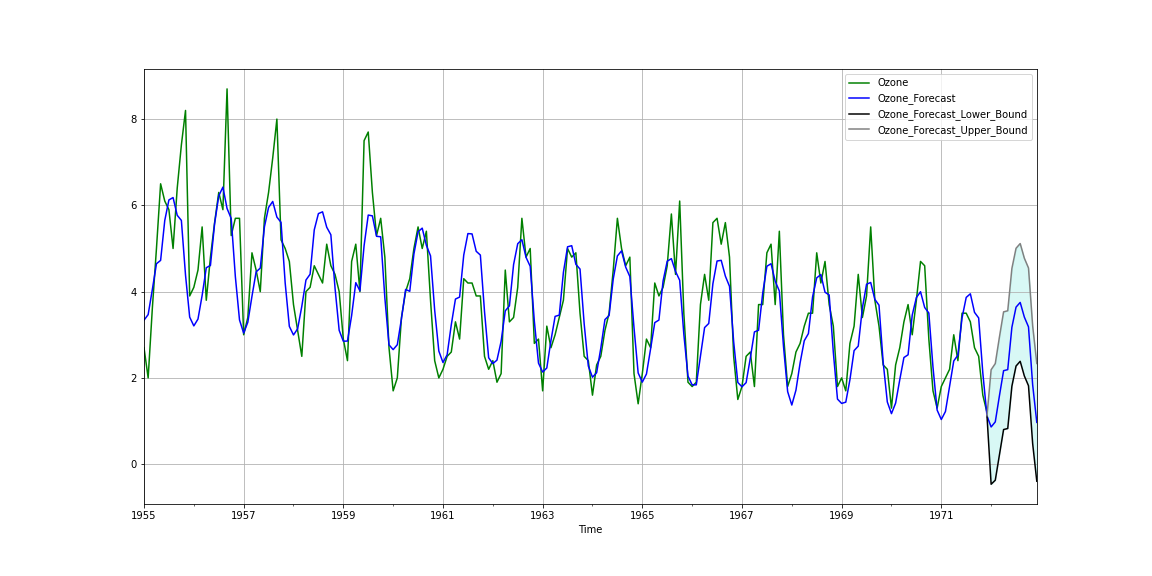

{'Ozone': {'Dataset': {'Time': {'TimeVariable': 'Time', 'TimeMinMax': ['1955-01-01 00:00:00', '1971-12-01 00:00:00'], 'Horizon': 12}, 'Signal': 'Ozone', 'Training_Signal_Length': 204}, 'Model': {'Best_Decomposition': '_Ozone_LinearTrend_residue_Seasonal_MonthOfYear_residue_LSTM(51)', 'Signal_Decomposition_Type': 'T+S+R', 'Signal_Transoformation': 'NoTransf', 'Trend': 'LinearTrend', 'Cycle': 'Seasonal_MonthOfYear', 'AR_Model': 'LSTM(51)'}, 'Model_Performance': {'MAPE': 0.1889, 'MASE': 0.7505, 'CRPS': 0.293, 'MAE': 0.5826, 'RMSE': 0.7075, 'MedAE': 0.5522, 'LnQ': 2.7236, 'COMPLEXITY': 64.0}}}



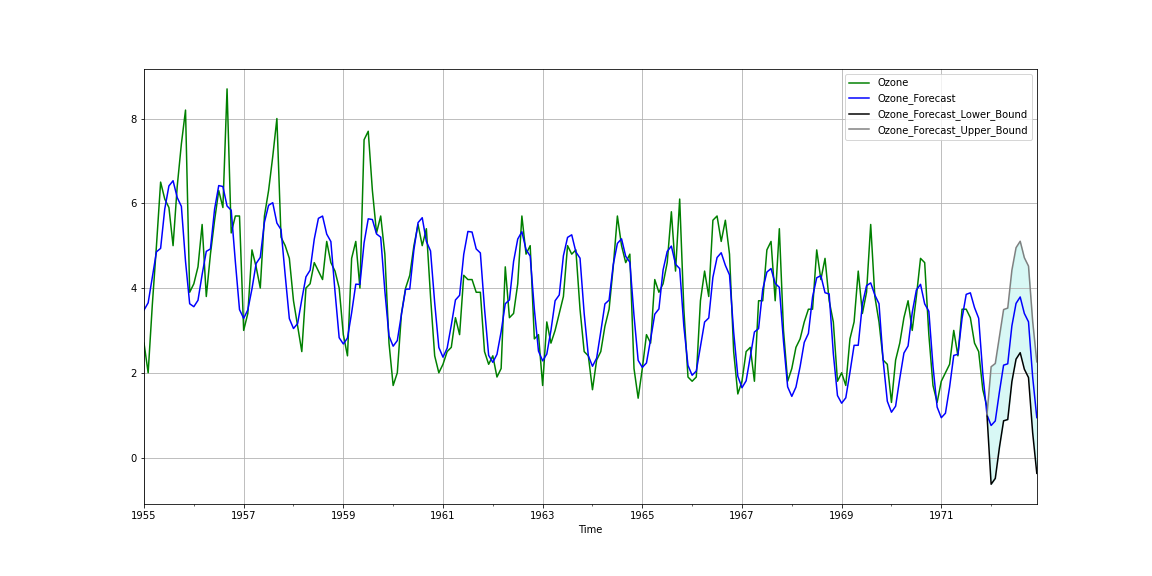

{'Ozone': {'Dataset': {'Time': {'TimeVariable': 'Time', 'TimeMinMax': ['1955-01-01 00:00:00', '1971-12-01 00:00:00'], 'Horizon': 12}, 'Signal': 'Ozone', 'Training_Signal_Length': 204}, 'Model': {'Best_Decomposition': '_Ozone_LinearTrend_residue_Seasonal_MonthOfYear_residue_LSTM(51)', 'Signal_Decomposition_Type': 'T+S+R', 'Signal_Transoformation': 'NoTransf', 'Trend': 'LinearTrend', 'Cycle': 'Seasonal_MonthOfYear', 'AR_Model': 'LSTM(51)'}, 'Model_Performance': {'MAPE': 0.1766, 'MASE': 0.7117, 'CRPS': 0.2857, 'MAE': 0.5525, 'RMSE': 0.6652, 'MedAE': 0.5624, 'LnQ': 2.2589, 'COMPLEXITY': 64.0}}}



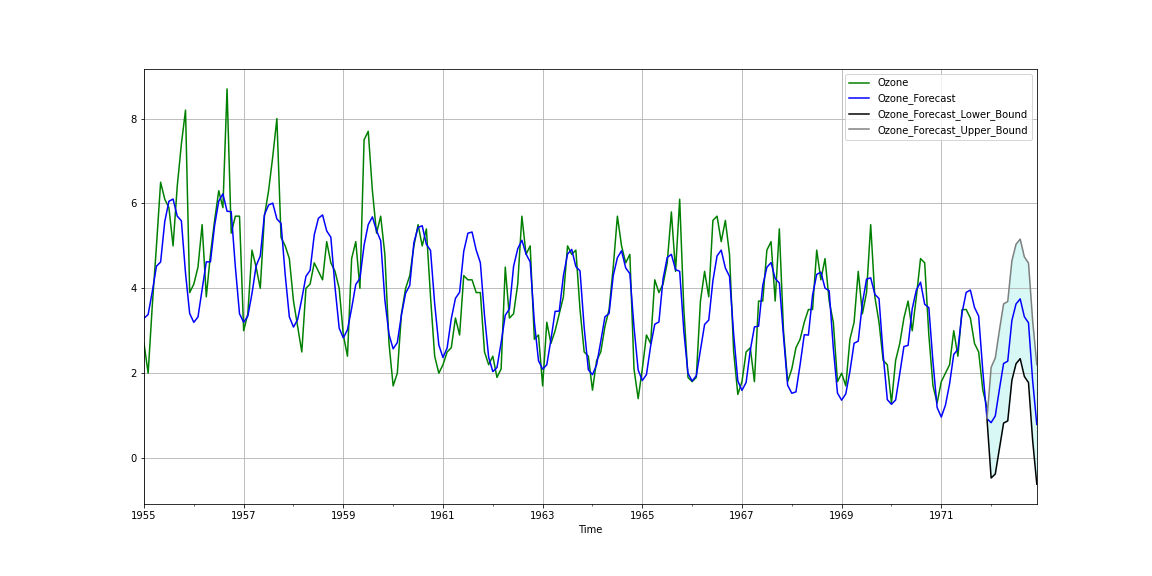

{'Ozone': {'Dataset': {'Time': {'TimeVariable': 'Time', 'TimeMinMax': ['1955-01-01 00:00:00', '1971-12-01 00:00:00'], 'Horizon': 12}, 'Signal': 'Ozone', 'Training_Signal_Length': 204}, 'Model': {'Best_Decomposition': '_Ozone_LinearTrend_residue_Seasonal_MonthOfYear_residue_LSTM(51)', 'Signal_Decomposition_Type': 'T+S+R', 'Signal_Transoformation': 'NoTransf', 'Trend': 'LinearTrend', 'Cycle': 'Seasonal_MonthOfYear', 'AR_Model': 'LSTM(51)'}, 'Model_Performance': {'MAPE': 0.1784, 'MASE': 0.72, 'CRPS': 0.2855, 'MAE': 0.559, 'RMSE': 0.6773, 'MedAE': 0.5484, 'LnQ': 2.2674, 'COMPLEXITY': 64.0}}}



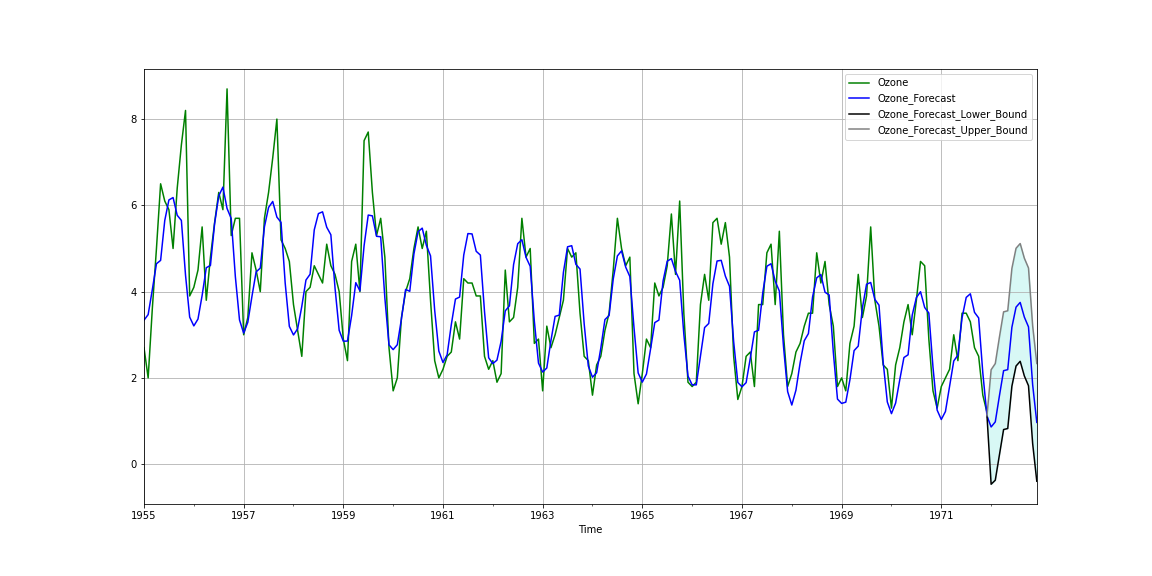

In [4]:

def test_reproducibility(iSeed):
    lEngine2 = autof.cForecastEngine()
    lEngine2.mOptions.mSeed = iSeed
    lEngine2.mOptions.set_active_autoregressions(['LSTM']);
    lEngine2.train(b1.mPastData , b1.mTimeVar , b1.mSignalVar, b1.mHorizon);
    print(lEngine2.to_dict())
    plot_prediction_intervals(lEngine2)

test_reproducibility(1789)
test_reproducibility(17890714)
test_reproducibility(17890804)
test_reproducibility(1789)


## Model Explainability

PyAF models are easy to explain. The model itself is a simple combination of easily explainable components.
The name of each component is self-explaining.

In the first example above, the name **_Ozone_LinearTrend_residue_bestCycle_byMAPE_residue_XGB(51)** refers to a nontransformed signal, with a linear trend, a cyclic component and an XGBboost regression on the last 51 lags of the cycle residues.

The second example s hows an additive decomposition of a linear trend , with a monthly  seasonal effect and a LSTM model.

```
{'Ozone': {'Dataset': {'Time': {'TimeVariable': 'Time', 'TimeMinMax': ['1955-01-01 00:00:00', '1971-12-01 00:00:00'], 'Horizon': 12}, 'Signal': 'Ozone', 'Training_Signal_Length': 204}, 'Model': {'Best_Decomposition': '_Ozone_LinearTrend_residue_Seasonal_MonthOfYear_residue_LSTM(51)', 'Signal_Decomposition_Type': 'T+S+R', 'Signal_Transoformation': 'NoTransf', 'Trend': 'LinearTrend', 'Cycle': 'Seasonal_MonthOfYear', 'AR_Model': 'LSTM(51)'}, 'Model_Performance': {'MAPE': 0.1889, 'MASE': 0.7505, 'CRPS': 0.293, 'MAE': 0.5826, 'RMSE': 0.7075, 'MedAE': 0.5522, 'LnQ': 2.7236, 'COMPLEXITY': 64.0}}}
```

## Model Outputs

PyAF allows forecasting the signal on the training dataframe or a similar dataframe (with the needed columns).

PyAF produces a new dataframe with a lot of columns, each column describes a step of the signal decomposition. These a columns are computed sequentially. The new dataframe also contains $H$ more rows representing the expected forecast data.

The first few columns contain the time, signal, row numbers and the transformed signal. The future time values are extrapolated based on the time resolution (detected from the training dataset).

The are columns for each component detected, and each component residue.

There are also additional columns for prediction intervals and forecast quantiles.

The naming convention for these columns makes them self-explaining.

In this example, the column for the signal forecast is 'Ozone_Forecast', the last $H$ values of 'Ozone_Forecast' column contain the forecast values for the signal.

In [5]:
df_output = lEngine.forecast(b1.mPastData, iHorizon=b1.mHorizon)
print("TRAINING_DATASET: ", b1.mPastData.shape)
print(b1.mPastData.columns)
print("FORECAST_DATASET: ", df_output.shape)
print(df_output.columns)


TRAINING_DATASET:  (204, 3)
Index(['Month', 'Ozone', 'Time'], dtype='object')
FORECAST_DATASET:  (216, 30)
Index(['Time', 'Ozone', 'row_number', 'Time_Normalized', '_Ozone',
       '_Ozone_LinearTrend', '_Ozone_LinearTrend_residue',
       '_Ozone_LinearTrend_residue_bestCycle_byMAPE',
       '_Ozone_LinearTrend_residue_bestCycle_byMAPE_residue',
       '_Ozone_LinearTrend_residue_bestCycle_byMAPE_residue_XGB(51)',
       '_Ozone_LinearTrend_residue_bestCycle_byMAPE_residue_XGB(51)_residue',
       '_Ozone_Trend', '_Ozone_Trend_residue', '_Ozone_Cycle',
       '_Ozone_Cycle_residue', '_Ozone_AR', '_Ozone_AR_residue',
       '_Ozone_TransformedForecast', 'Ozone_Forecast',
       '_Ozone_TransformedResidue', 'Ozone_Residue',
       'Ozone_Forecast_Lower_Bound', 'Ozone_Forecast_Upper_Bound',
       'Ozone_Forecast_Quantile_2', 'Ozone_Forecast_Quantile_18',
       'Ozone_Forecast_Quantile_34', 'Ozone_Forecast_Quantile_50',
       'Ozone_Forecast_Quantile_66', 'Ozone_Forecast_Quantile_82',


In [6]:
df_output.tail(b1.mHorizon)


,Time,Ozone,row_number,Time_Normalized,_Ozone,_Ozone_LinearTrend,_Ozone_LinearTrend_residue,_Ozone_LinearTrend_residue_bestCycle_byMAPE,_Ozone_LinearTrend_residue_bestCycle_byMAPE_residue,_Ozone_LinearTrend_residue_bestCycle_byMAPE_residue_XGB(51),...,Ozone_Residue,Ozone_Forecast_Lower_Bound,Ozone_Forecast_Upper_Bound,Ozone_Forecast_Quantile_2,Ozone_Forecast_Quantile_18,Ozone_Forecast_Quantile_34,Ozone_Forecast_Quantile_50,Ozone_Forecast_Quantile_66,Ozone_Forecast_Quantile_82,Ozone_Forecast_Quantile_98
204,1972-01-01,NaN,204,1.342196,NaN,0.182695,NaN,0,NaN,-0.215888,...,NaN,-0.492686,2.394786,-0.668551,0.351907,0.602309,0.890427,1.143358,1.357002,2.300144
205,1972-02-01,NaN,205,1.348898,NaN,0.181062,NaN,0,NaN,-0.111252,...,NaN,0.207124,3.240028,0.368312,0.809654,1.215009,1.489899,1.647476,2.090190,3.114619
206,1972-03-01,NaN,206,1.355166,NaN,0.179535,NaN,0,NaN,-0.046183,...,NaN,0.521791,3.878487,0.510337,1.328846,1.644825,1.867964,2.048135,2.603544,3.934826
207,1972-04-01,NaN,207,1.361868,NaN,0.177903,NaN,0,NaN,0.039387,...,NaN,0.995700,4.663644,0.721706,1.987160,2.206344,2.366621,2.638657,3.219752,4.428686
208,1972-05-01,NaN,208,1.368353,NaN,0.176323,NaN,0,NaN,0.097353,...,NaN,1.351567,5.153575,1.398633,2.130643,2.584621,2.762504,3.042945,3.658392,4.793847
209,1972-06-01,NaN,209,1.375054,NaN,0.174690,NaN,0,NaN,0.154575,...,NaN,1.612077,5.726901,1.486995,2.474388,2.922856,3.247737,3.661557,4.075310,5.259650
210,1972-07-01,NaN,210,1.381539,NaN,0.173110,NaN,0,NaN,0.202105,...,NaN,1.941810,6.086426,1.774954,2.852908,3.306456,3.626334,4.007809,4.419939,5.745961
211,1972-08-01,NaN,211,1.388240,NaN,0.171478,NaN,0,NaN,0.227497,...,NaN,2.174487,6.210127,2.064296,2.982364,3.484646,3.795575,4.189938,4.681159,5.861537
212,1972-09-01,NaN,212,1.394942,NaN,0.169845,NaN,0,NaN,0.060831,...,NaN,1.130991,4.729159,1.457930,1.803344,2.186776,2.462262,2.722689,3.482741,4.558829
213,1972-10-01,NaN,213,1.401427,NaN,0.168265,NaN,0,NaN,-0.101903,...,NaN,-0.009444,3.404876,0.461397,0.703392,1.011216,1.321333,2.002728,2.504581,3.176630
